In [1]:
cd ..

/Users/flamholz/Documents/workspace/ccm_evolution


In [2]:
!mkdir -p figures/fig3
!mkdir -p figures/fig4
!mkdir -p figures/fig6

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from autotroph_model import AutotrophModel
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statannot import add_stat_annotation


In [4]:
def blank_timeseries_df(df):
    # Find the blank columns, calculate the mean blank value
    columns = df.columns
    blank_cols = [c for c in columns if c.lower().startswith('blank')]
    blank_val = df[blank_cols].mean().mean()
    
    # Make a copy of the DF and subtract the blank off the per-well values
    # NOTE: the first few columns include metadata like temp and time. 
    blanked_df = df.copy()
    blanked_df[blanked_df.columns[4:]] -= blank_val
    
    return blanked_df

def blank_all_dfs(dfs):
    return [blank_timeseries_df(d) for d in dfs]

In [5]:
# Load data investigating effects of encapsulation
df_amb = pd.read_csv('data/Ecoli_CCMB1/EJD_2020_encapsulation_timecourses/090720_ED_OD600_ambientCO2.csv')
df_pt5pct = pd.read_csv('data/Ecoli_CCMB1/EJD_2020_encapsulation_timecourses/072720_ED_OD600_0.5pctCO2.csv')
df_1pt5pct = pd.read_csv('data/Ecoli_CCMB1/EJD_2020_encapsulation_timecourses/090720_ED_OD600_1.5pctCO2.csv')
df_5pct = pd.read_csv('data/Ecoli_CCMB1/EJD_2020_encapsulation_timecourses/072720_ED_OD600_5pctCO2.csv')

co2_dfs_encap = [df_amb, df_pt5pct, df_1pt5pct, df_5pct]
co2_dfs_encap_blanked = blank_all_dfs(co2_dfs_encap)
co2_conds = 'amb,0.5%,1.5%,5%'.split(',')

for co2, df in zip(co2_conds, co2_dfs_encap):
    max_th = df.time_s.max() / 60 /60 
    print('{0}: {1:.1f} hrs'.format(co2, max_th))

amb: 99.4 hrs
0.5%: 121.9 hrs
1.5%: 99.9 hrs
5%: 121.8 hrs


In [6]:
# Load data investigating effects of a futile cycle
df_pt5pct = pd.read_csv('data/Ecoli_CCMB1/EJD_2020_futile_cycle_data/011120_futile_cycle_0.5%.csv')
df_1pt5pct = pd.read_csv('data/Ecoli_CCMB1/EJD_2020_futile_cycle_data/011120_futile_cycle_1.5%.csv')
df_5pct = pd.read_csv('data/Ecoli_CCMB1/EJD_2020_futile_cycle_data/050321_futile_cycle_5%.csv')
df_amb = pd.read_csv('data/Ecoli_CCMB1/EJD_2020_futile_cycle_data/050321_futile_cycle_amb.csv')

co2_dfs_futcyc = [df_amb, df_pt5pct, df_1pt5pct, df_5pct]
co2_dfs_futcyc_blanked = blank_all_dfs(co2_dfs_futcyc)

for co2, df in zip(co2_conds, co2_dfs_futcyc):
    max_th = df.time_s.max() / 60 /60 
    print('{0}: {1:.1f} hrs'.format(co2, max_th))

amb: 107.3 hrs
0.5%: 119.0 hrs
1.5%: 120.7 hrs
5%: 107.3 hrs


In [7]:
# Make DataFrames with blanked endpoint data for encapsulation and futile cycle data.
# Note that each CO2 condition represents a different run on the plate reader as 
# the gas controller sets the CO2 concentration for the whole plate. In addition, 
# Individual plates were grown for different amounts of time due to plate reader
# availability (shared equipment) and a desire to let growing strains reach 
# stationary phase where possible. As such, we report the final OD measured as
# the endpoint OD in the main text, but give full curves in the supplementary figures.

# Encapsulation experiment
data_dict = {}
for cond, blanked_df in zip(co2_conds, co2_dfs_encap_blanked):
    columns = blanked_df.columns
    cols2drop = list(columns[:4])
    
    # drop the blanks and meta-data columns, take the rolling mean
    # of the density over 5 consecutive datapoints. 
    mean_df = blanked_df.drop(cols2drop, axis=1).rolling(5).mean()
    
    # The last measurement represents each sample. 
    endpoint_series = mean_df.iloc[-1]
    data_dict[cond] = endpoint_series
encap_endpoint_df = pd.DataFrame(data_dict)
encap_endpoint_df['strain'] = [idx.split('.')[0] for idx in encap_endpoint_df.index]
encap_endpoint_df = encap_endpoint_df.melt(id_vars=['strain'], value_name='endpoint_OD', var_name='CO2')


data_dict = {}
for cond, blanked_df in zip(co2_conds, co2_dfs_futcyc_blanked):
    columns = blanked_df.columns
    cols2drop = list(columns[:4])
    
    # drop the blanks and meta-data columns, take the rolling mean
    # of the density over 5 consecutive datapoints. 
    mean_df = blanked_df.drop(cols2drop, axis=1).rolling(5).mean()

    # The last measurement represents each sample. 
    endpoint_series = mean_df.iloc[-1]
    data_dict[cond] = endpoint_series
futcyc_endpoint_df = pd.DataFrame(data_dict)
futcyc_endpoint_df['strain'] = [idx.split(' ')[0] for idx in futcyc_endpoint_df.index]
futcyc_endpoint_df = futcyc_endpoint_df.melt(id_vars=['strain'], value_name='endpoint_OD', var_name='CO2')

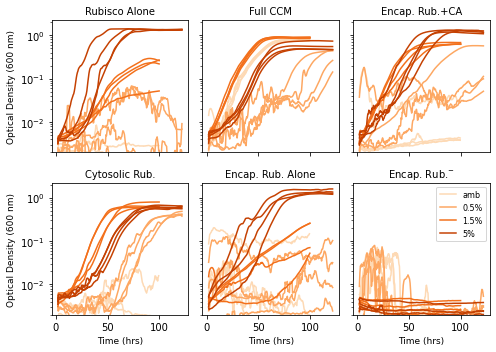

In [8]:
# SI figures with full growth trajectories for every strain & condition
# 1. Encapsulation experiment - 
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7,5), sharey=True, sharex=True)

xlim = (0, 100)
ylim = (0.002, 2.2)

# Base names of strains to plot from futile cycle exp
inactive_rub = "CCMB1:pCB' K194M+pCCM'"
rub_alone = "CCMB1:p1A+pFA-sfGFP"
rub_encap = "CCMB1:pCB' C173S+pFA-sfGFP"
rub_ca_encap = "CCMB1:pCB'+pFA-sfGFP"
rub_cyto_csome = "CCMB1:pCB' Y72R+pCCM'"
full_ccm = "CCMB1:pCB'+pCCM'"
strain_names_encap = [rub_alone, full_ccm, rub_ca_encap, rub_cyto_csome, rub_encap, inactive_rub]
titles_encap = 'Rubisco Alone,Full CCM,Encap. Rub.+CA,Cytosolic Rub.,Encap. Rub. Alone,Encap. Rub.$^{-}$'.split(',')

pal = sns.color_palette('Oranges', n_colors=4)
for strain, ax in zip(strain_names_encap, axs.flatten()):
    plt.sca(ax)
    cols = [strain+'.{0}'.format(i) for i in range(1,5)]
    for j, my_df in enumerate(co2_dfs_encap_blanked):
        time_h = my_df.time_s / 60 / 60
        label = co2_conds[j]
        for col in cols:
            # cultures that grow poorly show quite a lot of fluctuations in OD,
            # so we smooth the data for plotting. 
            smoothed = my_df[col].rolling(5).mean()
            plt.semilogy(time_h, smoothed, color=pal[j], label=label)
            label = None
    
for i, (title, ax) in enumerate(zip(titles_encap, axs.flatten())):
    plt.sca(ax)
    plt.title(title, fontsize=10, fontweight='medium')
    #plt.xlim(*xlim)
    plt.ylim(*ylim)
    
    if i%3 == 0:
        plt.ylabel('Optical Density (600 nm)', fontsize=9)
    if i > 2: 
        plt.xlabel('Time (hrs)', fontsize=9)

plt.legend(fontsize=8)

plt.tight_layout()
plt.savefig('figures/fig3/fig3S1_encap_growth_curves.png', dpi=600, facecolor='w')
plt.savefig('figures/fig3/fig3S1_encap_growth_curves.pdf', dpi=600, facecolor='w')

plt.show()

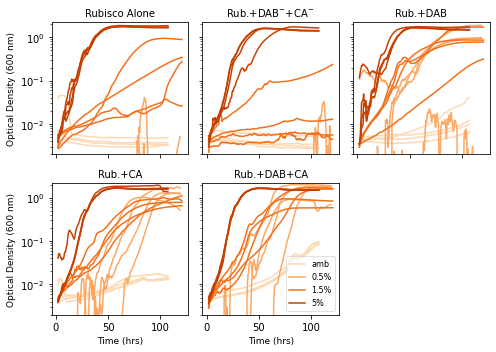

In [9]:
# SI figures with full growth trajectories for every strain & condition
# 2. futile cycle experiment
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7,5), sharex=True, sharey=True)

xlim = (0, 100)
ylim = (0.002, 2.2)

# Base names of strains to plot from futile cycle exp
rub_alone = "cLS/AGFP"
futile_cycle = "cLS/Dab2-Can"
plus_transport = "cLS/Dab2-dCan"
plus_ca = "cLS/dDab2-Can"
double_neg = "cLS/dDab2-dCan"
strain_names_futcyc = [rub_alone, double_neg, plus_transport, plus_ca, futile_cycle]
titles_futcyc = 'Rubisco Alone,Rub.+DAB$^{-}$+CA$^{-}$,Rub.+DAB,Rub.+CA,Rub.+DAB+CA'.split(',')

pal = sns.color_palette('Oranges', n_colors=4)
for strain, ax in zip(strain_names_futcyc, axs.flatten()):
    plt.sca(ax)
    cols = [strain+' {0}'.format(i) for i in range(1,5)]
    for j, my_df in enumerate(co2_dfs_futcyc_blanked):
        time_h = my_df.time_s / 60 / 60
        label = co2_conds[j]
        for col in cols:
            smoothed = my_df[col].rolling(5).mean()
            plt.semilogy(time_h, smoothed, color=pal[j], label=label)
            label = None
    
for i, (title, ax) in enumerate(zip(titles_futcyc, axs.flatten())):
    plt.sca(ax)
    plt.title(title, fontsize=10, fontweight='medium')
    plt.ylim(*ylim)
    
    if i%3 == 0:
        plt.ylabel('Optical Density (600 nm)', fontsize=9)
    if i > 2: 
        plt.xlabel('Time (hrs)', fontsize=9)
        
plt.sca(axs.flatten()[-1])
plt.axis('off')

plt.sca(axs[1, 1])
plt.legend(fontsize=8, loc=4, framealpha=0.6)

plt.tight_layout()
plt.savefig('figures/fig4/fig4S1_futcyc_growth_curves.png', dpi=600, facecolor='w')
plt.savefig('figures/fig4/fig4S1_futcyc_growth_curves.pdf', dpi=600, facecolor='w')

plt.show()

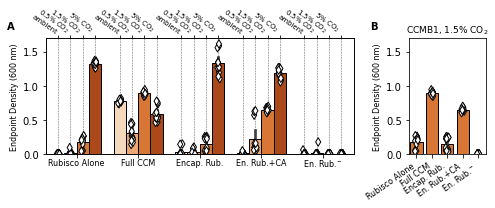

In [10]:
# Main text encapsulation figure, Fig. 3
fig, axs = plt.subplots(figsize=(7,3), ncols=2, gridspec_kw=dict(width_ratios=[4,1]))

# Left panel - co2 dependence of growth for all strains.
plt.sca(axs[0])
strip_pal = ['w']*4
oranges = sns.color_palette('Oranges', n_colors=4)
greys = sns.color_palette('Greys')

inactive_rub = "CCMB1:pCB' K194M+pCCM'"
rub_alone = "CCMB1:p1A+pFA-sfGFP"
rub_encap = "CCMB1:pCB' C173S+pFA-sfGFP"
rub_ca_encap = "CCMB1:pCB'+pFA-sfGFP"
full_ccm = "CCMB1:pCB'+pCCM'"
strain_names_encap = [rub_alone, full_ccm, rub_encap, rub_ca_encap, inactive_rub]
titles_encap = 'Rubisco Alone,Full CCM,Encap. Rub.,En. Rub.+CA,En. Rub.$^{-}$'.split(',')

sns.barplot(data=encap_endpoint_df,
            x='strain', y='endpoint_OD', hue='CO2',
            order=strain_names_encap, hue_order=co2_conds,
            dodge=0.25, edgecolor='k', palette=oranges)
sns.stripplot(data=encap_endpoint_df,
              x='strain', y='endpoint_OD', hue='CO2', 
              order=strain_names_encap, hue_order=co2_conds, dodge=0.25,
              size=6, marker='d', edgecolor='k', linewidth=1, palette=strip_pal)
xlocs = np.arange(len(titles_encap))
xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.xticks(xlocs, titles_encap, fontsize=8, ha='center', va='center')
plt.tick_params(axis='x', which='major', pad=5)
plt.xlabel('')
plt.ylim(0, ylim[1])
plt.ylabel('Endpoint Density (600 nm)', fontsize=8)
plt.legend().set_visible(False)

axs[0].text(-0.1, 1.15, 'A', transform=axs[0].transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')
xticks = np.arange(0, 0.8, 0.2) - 0.3
xticks = np.hstack([xticks, xticks+1, xticks+2, xticks+3, xticks+4])
xtick_str = 'ambient,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$'.split(',')*5

for xpos in xticks:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[-2])

axT = plt.gca().twiny()
plt.sca(axT)
plt.xlim(xlim)
plt.xticks(xticks, xtick_str, ha='right', rotation=-35, fontsize=7)
plt.tick_params(pad=0)

plt.sca(axs[1])

mask = encap_endpoint_df['CO2'] == '1.5%'
sub_df = encap_endpoint_df[mask]
sns.barplot(data=sub_df,
            x='strain', y='endpoint_OD', 
            order=strain_names_encap,
            dodge=0.25, edgecolor='k', color=oranges[2])
sns.stripplot(data=sub_df,
              x='strain', y='endpoint_OD', 
              order=strain_names_encap, dodge=0.25,
              size=6, marker='d', edgecolor='k', linewidth=1, palette=strip_pal)

axs[1].text(-0.4, 1.15, 'B', transform=axs[1].transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')
plt.title('CCMB1, 1.5% CO$_2$', fontsize=9)
plt.xticks(xlocs, titles_encap, fontsize=8, ha='right', rotation=35)
plt.ylim(0, ylim[1])
plt.xlabel('')
plt.ylabel('Endpoint Density (600 nm)', fontsize=8)

plt.tight_layout()
plt.savefig('figures/fig3/fig3_encapsulation.png', dpi=600, facecolor='w')
plt.savefig('figures/fig3/fig3_encapsulation.pdf', dpi=600, facecolor='w')

plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

5%_CCMB1:p1A+pFA-sfGFP v.s. 5%_CCMB1:pCB'+pCCM': Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.854e-04 U_stat=1.440e+02
amb_CCMB1:p1A+pFA-sfGFP v.s. amb_CCMB1:pCB'+pCCM': Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.854e-04 U_stat=0.000e+00
0.5%_CCMB1:p1A+pFA-sfGFP v.s. 0.5%_CCMB1:pCB'+pCCM': Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.854e-04 U_stat=0.000e+00
1.5%_CCMB1:p1A+pFA-sfGFP v.s. 1.5%_CCMB1:pCB'+pCCM': Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.854e-04 U_stat=0.000e+00
5%_CCMB1:p1A+pFA-sfGFP v.s. 5%_CCMB1:pCB' C173S+pFA-sfGFP: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.700e+01
amb_CCMB1:p1A+pFA-sfGFP v.s. amb_CCMB1:pCB' C173S+pFA-sfGFP: Mann-Whitney-Wilcoxo

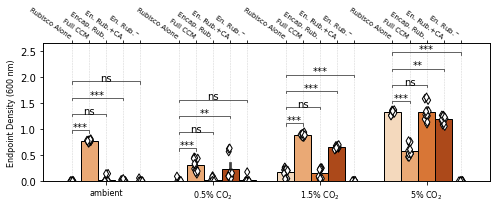

In [11]:
# Encapsulation figure with statistical comparisons for SI
fig, ax = plt.subplots(figsize=(7,3))

strip_pal = ['w']*4
oranges = sns.color_palette('Oranges', n_colors=4)
greys = sns.color_palette('Greys')

sns.barplot(data=encap_endpoint_df,
            x='CO2', y='endpoint_OD', hue='strain',
            order=co2_conds, hue_order=strain_names_encap,
            dodge=0.25, edgecolor='k', palette=oranges)
sns.stripplot(data=encap_endpoint_df,
              x='CO2', y='endpoint_OD', hue='strain', 
              order=co2_conds, hue_order=strain_names_encap, dodge=0.25,
              size=6, marker='d', edgecolor='k', linewidth=1, palette=strip_pal)
co2_ticks = 'ambient,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$'.split(',')
xlocs = np.arange(len(co2_ticks))
plt.xticks(xlocs, co2_ticks, fontsize=8)
plt.xlabel('')
plt.ylim(0, 2.1)
plt.ylabel('Endpoint Density (600 nm)', fontsize=8)
plt.legend().set_visible(False)

pairs = []
for s in strain_names_encap[1:]:
    for c in co2_conds:
        pair = ((c, strain_names_encap[0]), (c, s))
        pairs.append(pair)
test_results = add_stat_annotation(
    ax, data=encap_endpoint_df, x='CO2', y='endpoint_OD', hue='strain',
    order=co2_conds, hue_order=strain_names_encap,
    box_pairs=pairs,
    test='Mann-Whitney', 
    text_format='star', text_offset=-2,
    line_height=0.02, line_offset=0.08, linewidth=0.75,
    loc='inside', verbose=2)

xticks = np.arange(0, 0.8, 0.16) - 0.32
xticks = np.hstack([xticks, xticks+1, xticks+2, xticks+3])
xtick_str = titles_encap*4 

for xpos in xticks:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[1])

axT = plt.gca().twiny()
plt.sca(axT)
plt.xlim(ax.get_xlim())
plt.xticks(xticks, xtick_str, ha='right', rotation=-35, fontsize=7)
plt.tick_params(pad=0)

plt.tight_layout()
plt.savefig('figures/fig3/fig3S2_stats.png', dpi=600, facecolor='w')
plt.savefig('figures/fig3/fig3S2_stats.pdf', dpi=600, facecolor='w')

plt.show()

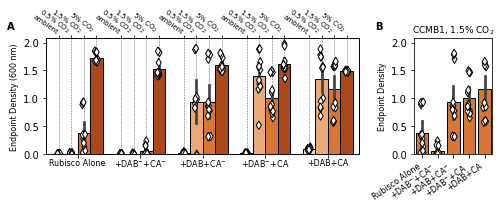

In [12]:
# Main-text futile cycle figure, Fig. 4
fig, axs = plt.subplots(figsize=(7,3), ncols=2, gridspec_kw=dict(width_ratios=[4,1]))

plt.sca(axs[0])
strip_pal = ['w']*4
oranges = sns.color_palette('Oranges', n_colors=4)
greys = sns.color_palette('Greys')

rub_alone = "cLS/AGFP"
futile_cycle = "cLS/Dab2-Can"
plus_transport = "cLS/Dab2-dCan"
plus_ca = "cLS/dDab2-Can"
double_neg = "cLS/dDab2-dCan"
strain_names_futcyc = [rub_alone, double_neg, plus_transport, plus_ca, futile_cycle]
titles_futcyc = 'Rubisco Alone,+DAB$^{-}$+CA$^{-}$,+DAB+CA$^{-}$,+DAB$^{-}$+CA,+DAB+CA'.split(',')

sns.barplot(data=futcyc_endpoint_df,
            x='strain', y='endpoint_OD', hue='CO2',
            order=strain_names_futcyc, hue_order=co2_conds,
            dodge=0.25, edgecolor='k', palette=oranges)
sns.stripplot(data=futcyc_endpoint_df,
              x='strain', y='endpoint_OD', hue='CO2',
              order=strain_names_futcyc, hue_order=co2_conds, dodge=0.25,
              size=6, marker='d', edgecolor='k', linewidth=1, palette=strip_pal)
xlocs = np.arange(len(titles_futcyc))
xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.xticks(xlocs, titles_futcyc, fontsize=8, va='center')
plt.tick_params(axis='x', which='major', pad=5)
plt.xlabel('')
plt.ylim(0, ylim[1])
plt.ylabel('Endpoint Density (600 nm)', fontsize=8)
plt.yticks(np.arange(0, 2.1, 0.5))
plt.legend().set_visible(False)

axs[0].text(-0.1, 1.15, 'A', transform=axs[0].transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')
xticks = np.arange(0, 0.8, 0.2) - 0.3
xticks = np.hstack([xticks, xticks+1, xticks+2, xticks+3, xticks+4])
xtick_str = 'ambient,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$'.split(',')*5

for xpos in xticks:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[-2])

axT = plt.gca().twiny()
plt.sca(axT)
plt.xlim(xlim)
plt.xticks(xticks, xtick_str, ha='right', rotation=-35, fontsize=7)
plt.tick_params(pad=0)

plt.sca(axs[1])

mask = futcyc_endpoint_df['CO2'] == '1.5%'
sub_df = futcyc_endpoint_df[mask]
sns.barplot(data=sub_df,
            x='strain', y='endpoint_OD', 
            order=strain_names_futcyc,
            dodge=0.25, edgecolor='k', color=oranges[2])
sns.stripplot(data=sub_df,
              x='strain', y='endpoint_OD', 
              order=strain_names_futcyc, dodge=0.25,
              size=6, marker='d', edgecolor='k', linewidth=1, palette=strip_pal)

axs[1].text(-0.4, 1.15, 'B', transform=axs[1].transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')
plt.title('CCMB1, 1.5% CO$_2$', fontsize=9)
plt.xticks(xlocs, titles_futcyc, fontsize=8, ha='right', rotation=35)
plt.ylim(0, ylim[1])
plt.xlabel('')
plt.ylabel('Endpoint Density', fontsize=8)

plt.tight_layout()
plt.savefig('figures/fig4/fig4_futile_cycle.png', dpi=600, facecolor='w')
plt.savefig('figures/fig4/fig4_futile_cycle.pdf', dpi=600, facecolor='w')

plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

5%_cLS/AGFP v.s. 5%_cLS/dDab2-dCan: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.713e-02 U_stat=1.240e+02
amb_cLS/AGFP v.s. amb_cLS/dDab2-dCan: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.010e+02
0.5%_cLS/AGFP v.s. 0.5%_cLS/dDab2-dCan: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+01
1.5%_cLS/AGFP v.s. 1.5%_cLS/dDab2-dCan: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.170e-02 U_stat=1.310e+02
5%_cLS/AGFP v.s. 5%_cLS/Dab2-dCan: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.631e-01 U_stat=1.170e+02
amb_cLS/AGFP v.s. amb_cLS/Dab2-dCan: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.831e-04 U_stat=0.000e+00
0.5%_cLS/AGFP v.s. 0.5

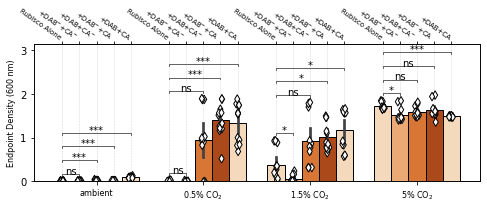

In [13]:
# Encapsulation figure
fig, ax = plt.subplots(figsize=(7,3))

strip_pal = ['w']*4
oranges = sns.color_palette('Oranges', n_colors=4)
greys = sns.color_palette('Greys')

sns.barplot(data=futcyc_endpoint_df,
            x='CO2', y='endpoint_OD', hue='strain',
            order=co2_conds, hue_order=strain_names_futcyc,
            dodge=0.25, edgecolor='k', palette=oranges)
sns.stripplot(data=futcyc_endpoint_df,
              x='CO2', y='endpoint_OD', hue='strain', 
              order=co2_conds, hue_order=strain_names_futcyc, dodge=0.25,
              size=6, marker='d', edgecolor='k', linewidth=1, palette=strip_pal)
co2_ticks = 'ambient,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$'.split(',')
xlocs = np.arange(len(co2_ticks))
plt.xticks(xlocs, co2_ticks, fontsize=8)
plt.xlabel('')
plt.ylim(0, 2.1)
plt.ylabel('Endpoint Density (600 nm)', fontsize=8)
plt.legend().set_visible(False)

pairs = []
for s in strain_names_futcyc[1:]:
    for c in co2_conds:
        pair = ((c, strain_names_futcyc[0]), (c, s))
        pairs.append(pair)
test_results = add_stat_annotation(
    ax, data=futcyc_endpoint_df, x='CO2', y='endpoint_OD', hue='strain',
    order=co2_conds, hue_order=strain_names_futcyc,
    box_pairs=pairs,
    test='Mann-Whitney', 
    text_format='star', text_offset=-2,
    line_height=0.02, line_offset=0.08, linewidth=0.75,
    loc='inside', verbose=2)

xticks = np.arange(0, 0.8, 0.16) - 0.32
xticks = np.hstack([xticks, xticks+1, xticks+2, xticks+3])
xtick_str = titles_futcyc*4 

for xpos in xticks:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[1])

axT = plt.gca().twiny()
plt.sca(axT)
plt.xlim(ax.get_xlim())
plt.xticks(xticks, xtick_str, ha='right', rotation=-35, fontsize=7)
plt.tick_params(pad=0)

plt.tight_layout()
plt.savefig('figures/fig4/fig4S2_stats.png', dpi=600, facecolor='w')
plt.savefig('figures/fig4/fig4S2_stats.pdf', dpi=600, facecolor='w')
plt.show()

<ipython-input-14-c0af8a8d25d7>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


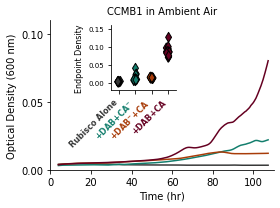

In [14]:
##### Futile cycle ambient zoom in.
# Need to figure out colors & placement for main text.
fig = plt.figure(figsize=(4,3))

rub_alone = "cLS/AGFP"
futile_cycle = "cLS/Dab2-Can"
plus_transport = "cLS/Dab2-dCan"
plus_ca = "cLS/dDab2-Can"
double_neg = "cLS/dDab2-dCan"
strain_names = [rub_alone, plus_transport, plus_ca, futile_cycle]
#titles = 'Rubisco Alone,Rub.+DAB,Rub.+CA,Rub.+DAB+CA'.split(',')
titles = 'Rubisco Alone,+DAB+CA$^{-}$,+DAB$^{-}$+CA,+DAB+CA'.split(',')

# Outer plot - timecourse data for futile cycle
amb_df = co2_dfs_futcyc_blanked[0]

pal = ['dark grey', 'blue green', 'rust', 'maroon',]
pal = sns.xkcd_palette(pal)
for i, strain in enumerate(strain_names):
    cols = ['{0} 2.2'.format(strain)]
    time_h = amb_df.time_s / 60 / 60
    label = titles[i]
    for col in cols:
        ods = amb_df[col].rolling(5).mean().rolling(5).mean()
        plt.plot(time_h, ods, color=pal[i], label=label)
        label = None

plt.legend(loc=1, fontsize=7).set_visible(False)
plt.title('CCMB1 in Ambient Air', fontsize=10)
plt.xlabel('Time (hr)', fontsize=10)
plt.ylabel('Optical Density (600 nm)', fontsize=10)
plt.ylim(0.00, 0.11)
plt.xlim(0, 110)
plt.yticks(np.arange(0.0, 0.11, 0.05))

ax0 = plt.gca()
axins = inset_axes(ax0, width=0.9, height=0.9, loc=2,
                   bbox_to_anchor=(.25, .5, .6, .5),
                   bbox_transform=ax0.transAxes)
plt.sca(axins)

mask = futcyc_endpoint_df['CO2'] == 'amb'
amb_endpoint_df = futcyc_endpoint_df[mask]
sns.stripplot(data=amb_endpoint_df, x='strain', y='endpoint_OD', order=strain_names,
              marker='d', color='w', edgecolor='k', linewidth=1, size=7, palette=pal)

plt.xticks(np.arange(len(titles)), titles, fontsize=8, rotation=45, ha='right', weight='bold')
plt.yticks(np.arange(0.0, 0.151, 0.05), fontsize=7)

plt.xlabel('')
plt.ylim(-0.02, 0.16)
plt.xlim(-0.5, 3.5)
plt.ylabel('Endpoint Density', fontsize=8)
sns.despine()

for ticklabel, tickcolor in zip(axins.get_xticklabels(), pal):
    ticklabel.set_color(tickcolor)

plt.tight_layout()
plt.savefig('figures/fig6/fig6_futile_cycle_amb.png', dpi=600, facecolor='w')
plt.savefig('figures/fig6/fig6.pdf', dpi=600, facecolor='w')
plt.show()

<ipython-input-15-05ec47ad4c6e>:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0.00, 0.11)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

cLS/AGFP v.s. cLS/Dab2-dCan: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.093e-04 U_stat=0.000e+00
cLS/AGFP v.s. cLS/dDab2-Can: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.093e-04 U_stat=0.000e+00
cLS/AGFP v.s. cLS/Dab2-Can: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.093e-04 U_stat=0.000e+00


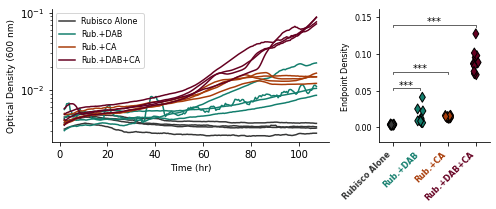

In [15]:
##### Futile cycle ambient zoom in.
fig, axs = plt.subplots(figsize=(7,3), ncols=2, gridspec_kw=dict(width_ratios=[2.5,1]))

rub_alone = "cLS/AGFP"
futile_cycle = "cLS/Dab2-Can"
plus_transport = "cLS/Dab2-dCan"
plus_ca = "cLS/dDab2-Can"
double_neg = "cLS/dDab2-dCan"
strain_names = [rub_alone, plus_transport, plus_ca, futile_cycle]
titles = 'Rubisco Alone,Rub.+DAB,Rub.+CA,Rub.+DAB+CA'.split(',')

plt.sca(axs[0])
plt.yscale('log')
amb_df = co2_dfs_futcyc_blanked[0]

pal = ['dark grey', 'blue green', 'rust', 'maroon',]
pal = sns.xkcd_palette(pal)
for i, strain in enumerate(strain_names):
    cols = ['{0} {1}.2'.format(strain, i) for i in range(1,5)]
    time_h = amb_df.time_s / 60 / 60
    label = titles[i]
    for col in cols:
        ods = amb_df[col].rolling(5).mean()
        plt.plot(time_h, ods, color=pal[i], label=label)
        label = None

plt.legend(loc=2, fontsize=8)
plt.xlabel('Time (hr)', fontsize=9)
plt.ylabel('Optical Density (600 nm)', fontsize=9)
plt.ylim(0.00, 0.11)
#plt.yticks(np.arange(0.00, 0.11, 0.05))

plt.sca(axs[1])
mask = futcyc_endpoint_df['CO2'] == 'amb'
amb_endpoint_df = futcyc_endpoint_df[mask]
sns.stripplot(data=amb_endpoint_df, x='strain', y='endpoint_OD', order=strain_names,
              marker='d', color='w', edgecolor='k', linewidth=1, size=7, palette=pal)

plt.xticks(np.arange(len(titles)), titles, fontsize=8, rotation=45, ha='right', weight='bold')
plt.yticks(np.arange(0.0, 0.151, 0.05), fontsize=8)

pairs = [(strain_names[0], s) for s in strain_names[1:]]
test_results = add_stat_annotation(
    axs[1], data=amb_endpoint_df, x='strain', y='endpoint_OD', order=strain_names,
    box_pairs=pairs,
    test='Mann-Whitney', 
    text_format='star', text_offset=-2,
    line_height=0.02, line_offset=0.08, linewidth=0.75,
    loc='inside', verbose=2)

plt.xlabel('')
plt.ylim(-0.02, 0.16)
plt.xlim(-0.5, 3.5)
plt.ylabel('Endpoint Density', fontsize=8)
sns.despine()

for ticklabel, tickcolor in zip(axs[1].get_xticklabels(), pal):
    ticklabel.set_color(tickcolor)

plt.tight_layout()
plt.savefig('figures/fig6/fig6S1_futile_cycle_amb.png', dpi=600, facecolor='w')
plt.savefig('figures/fig6/fig6S1_futile_cycle_amb.pdf', dpi=600, facecolor='w')
plt.show()
